In [48]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
import matplotlib.patches as patches
import pandas as pd
from tqdm import tqdm
import cv2
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage import feature
import pickle
from sklearn.preprocessing import StandardScaler
import random
import pickle

In [49]:
from cars_detector.utils  import read_test_frame, read_frame
from cars_detector.sampling import sampling
from cars_detector.augmentation import random_augmentation
from cars_detector.features import compute_features, compute_colors_features
from cars_detector.makebox import non_max_suppression, box_otsu
from cars_detector.splitpictures import pyramid

In [50]:
df_ground_truth = pd.read_csv('train.csv')

## Sampling of positive and negative examples

In [51]:
total_positive_samples, total_negative_samples = sampling(df_ground_truth)

 72%|███████▏  | 1604/2225 [03:25<01:39,  6.23it/s]

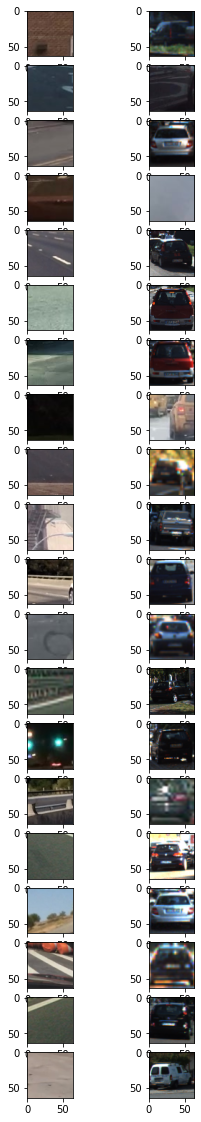

In [ ]:
# samples visualisation
number_of_positive_samples = len(total_positive_samples)
number_of_negative_samples = len(total_negative_samples)
fig, ax = plt.subplots(20,2,figsize=(4, 20))
for i in range(20):
    for j in range(2):
        if j == 0:
            img = total_negative_samples[np.random.randint(number_of_negative_samples)]
        else:
            img = total_positive_samples[np.random.randint(number_of_positive_samples)]
        ax[i][j].imshow(img)

## Data Augmentation

In [ ]:
new_positive_samples = []
new_negative_samples = []
thresh = 0.2
for img in tqdm(total_positive_samples, position = 0):
    r = np.random.rand(1)
    if r <= thresh:
        new_img = random_augmentation(img)
        new_positive_samples.append(new_img)

for img in tqdm(total_negative_samples, position = 0):
    r = np.random.rand(1)
    if r <= thresh:
        new_img = random_augmentation(img)
        new_negative_samples.append(new_img)

total_positive_samples.extend(new_positive_samples)
total_negative_samples.extend(new_negative_samples)

  0%|          | 0/10792 [00:00<?, ?it/s]c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\cars_detection\venv\lib\site-packages\skimage\_shared\utils.py:293: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
100%|██████████| 16968/16968 [00:01<00:00, 9114.70it/s] 


In [ ]:
print(f"number of positive samples: {len(total_positive_samples)}")
print(f"number of negative samples: {len(total_negative_samples)}")

number of positive samples: 11912
number of negative samples: 18697


## Compute Sift Features

In [ ]:
from cv2 import SIFT_create
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances
import pickle
import numpy as np
from tqdm import tqdm

# initialise SIFT object
sift = SIFT_create()

def build_vocabulary(images_array, vocab_size = 500):
    """
    This function will sample SIFT descriptors from the training images,
    cluster them with kmeans, and then return the cluster centers.
    Args:
    -   image_paths: list of image paths.
    -   vocab_size: size of vocabulary (cluster centers)
    Returns:
    -   vocab: This is a vocab_size x d numpy array (vocabulary). Each row is a
      cluster center / visual word
    """

    dim = 128         # length of the SIFT descriptors that you are going to compute.
    features = []
    for img in tqdm(images_array, position = 0):
        try:
            kp, des_list = sift.detectAndCompute(img, None)
            for des in des_list:
                if len(des) == 128:
                    features.append(des)
        except:
            continue
    kmean = MiniBatchKMeans(vocab_size)
    kmean.fit_predict(features)
    vocab = kmean.cluster_centers_
    return np.array(vocab)

def get_bags_of_sifts(images_array, vocab_filename, vocab_size = 500):
    # load vocabulary
    with open(vocab_filename, 'rb') as f:
        vocab = pickle.load(f)

     
    features = []
    for img in tqdm(images_array, position = 0):
        kp, des = sift.detectAndCompute(img, None)

        dists = pairwise_distances(vocab, des)
        argmin = np.argmin(dists,0)
        hist = np.bincount(argmin,minlength = vocab_size)
        hist = hist/np.sum(hist)

        features.append(hist)

    return features

In [ ]:
images_array = np.concatenate((total_positive_samples,total_negative_samples), axis = 0)
vocab = build_vocabulary(images_array, vocab_size = 500)
pickle.dump(vocab, open('data/vocab/vocab.pkl', 'wb'))

100%|██████████| 30609/30609 [01:12<00:00, 424.23it/s]


In [ ]:
features = get_bags_of_sifts(images_array, 'data/vocab/vocab.pkl')
pickle.dump(features, open('data/features/sift_features.pkl', 'wb'))

100%|██████████| 30609/30609 [02:48<00:00, 182.02it/s]


In [ ]:
len(features)

30609

## Train Classifier

In [ ]:
from sklearn.model_selection import train_test_split
X = features
y = np.array([1 for i in range(len(total_positive_samples))]+[0 for i in range(len(total_negative_samples))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y, shuffle = True)

# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(np.float32(X_train))
X_test = scaler.transform(np.float32(X_test))

In [ ]:
clf = XGBClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"accuracy: {acc}")


accuracy: 0.844985298921921


## Cars detection

In [ ]:
# Extracts features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler, ystart_ystop_scale, vocab, h_shift=0, visualisation=False):
    # List of bounding box positions
    bbox_detection_list=[]
    box_vis_list=[]
    # Copy and normalise
    draw_img = np.copy(img)
    pred_array = np.zeros((img.shape[0], img.shape[1]))
       
    # Searching different size windows at different scales:
    for (ystart, ystop, scale) in ystart_ystop_scale:
        box_vis=[]
        # Crop
        ctrans_tosearch = img[ystart:ystop, :, :]
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int32(imshape[1]/scale), np.int32(imshape[0]/scale)))


        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        x_size = ctrans_tosearch.shape[1]
        y_size = ctrans_tosearch.shape[0]
        step = 8

        for xb in range(0, x_size, step):
            for yb in range(0, y_size, step):
                    
                xleft = np.int32(xb*scale)
                ytop = np.int32(yb*scale)

                # Extract the image patch
                try:
                    crop = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window,window))
                except:
                    continue
                # compute features
             
                features = [] 
                kp, des = sift.detectAndCompute(crop, None)
                dists = pairwise_distances(vocab, des)
                argmin = np.argmin(dists,0)
                hist = np.bincount(argmin,minlength = 300)
                hist = hist/np.sum(hist)
                features.append(hist)
                

                # Scale features and make a prediction
                test_features = X_scaler.transform(features)    

                # Make prediction based on trained model 
                test_prediction = svc.predict(test_features)
                
                if(visualisation):
                    xbox_left = np.int32(xleft*scale)
                    ytop_draw = np.int32(ytop*scale)
                    win_draw = np.int32(window*scale)
                    # Append Detection Position to list 
                    box_vis.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
                if test_prediction == 1:
                    xbox_left = np.int32(xleft*scale)
                    ytop_draw = np.int32(ytop*scale)
                    win_draw = np.int32(window*scale)
                    # Append Detection Position to list 
                    bbox_detection_list.append([xbox_left+h_shift,ytop_draw+ystart,win_draw,win_draw])
                    pred_array[ytop_draw+ystart:ytop_draw+ystart+win_draw, xbox_left+h_shift:xbox_left+h_shift+win_draw] += 1

                   
    return bbox_detection_list, pred_array

In [ ]:
def filter_boxes(bboxes,pred_array):
    boxes_to_keep = []
    means_list = []

    bin =  np.bincount(pred_array.ravel().astype('int'))
    threshold = np.argmax(bin/np.cumsum(bin) < 0.1)

    for box in bboxes:
        if len(box) > 0:
            try:
                mean_pred = np.mean(pred_array[box[1]:box[1]+box[3], box[0]:box[0]+box[2]])
                means_list.append(mean_pred)
                if mean_pred > threshold:
                    boxes_to_keep.append(box)
            except:
                continue
    return(boxes_to_keep)

In [ ]:
def non_max_suppression(boxes, overlapThresh = 0.4):
    # Return an empty list, if no boxes given
    if len(boxes) == 0:
        return []
    x1 = boxes[:, 0]  # x coordinate of the top-left corner
    y1 = boxes[:, 1]  # y coordinate of the top-left corner
    x2 = x1+boxes[:, 2]  # x coordinate of the bottom-right corner
    y2 = y1+boxes[:, 3]  # y coordinate of the bottom-right corner
    # Compute the area of the bounding boxes and sort the bounding
    # Boxes by the bottom-right y-coordinate of the bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1) # We add 1, because the pixel at the start as well as at the end counts
    # The indices of all boxes at start. We will redundant indices one by one.
    indices = np.arange(len(x1))
    for i,box in enumerate(boxes):
        # Create temporary indices  
        temp_indices = indices[indices!=i]
        # Find out the coordinates of the intersection box
        xx1 = np.maximum(box[0], boxes[temp_indices,0])
        yy1 = np.maximum(box[1], boxes[temp_indices,1])
        xx2 = np.minimum(box[0]+box[2], boxes[temp_indices,0]+boxes[temp_indices,2])
        yy2 = np.minimum(box[1]+box[3], boxes[temp_indices,1]+boxes[temp_indices,3])
        # Find out the width and the height of the intersection box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / areas[temp_indices]
        # if the actual boungding box has an overlap bigger than treshold with any other box, remove it's index  
        if np.any(overlap) > overlapThresh:
            indices = indices[indices != i]
    #return only the boxes at the remaining indices

    boxes = boxes[indices].astype(int)
    new_boxes = []
    for box in boxes:
        dx = box[2]
        dy = box[3]
        if dx/dy <= 4 and dx/dy >= 1/4 and dx > 50 and dy > 50:
            new_boxes.append(box)
    return new_boxes

In [ ]:
def bounding_boxes_to_mask(bounding_boxes, H, W):
    
    """
    Converts set of bounding boxes to a binary mask
    """

    mask = np.zeros((H, W))
    for x, y, dx, dy in bounding_boxes:
        mask[y:y+dy, x:x+dx] = 1

    return mask

def run_length_encoding(mask):

    """
    Produces run length encoding for a given binary mask
    """
    
    # find mask non-zeros in flattened representation
    non_zeros = np.nonzero(mask.flatten())[0]
    padded = np.pad(non_zeros, pad_width=1, mode='edge')
    
    # find start and end points of non-zeros runs
    limits = (padded[1:] - padded[:-1]) != 1
    starts = non_zeros[limits[:-1]]
    ends = non_zeros[limits[1:]]
    lengths = ends - starts + 1

    return ' '.join(['%d %d' % (s, l) for s, l in zip(starts, lengths)])

In [ ]:
from skimage.io import imread
images_list = os.listdir('test/')
submission_df = pd.read_csv('sample_submission.csv')
submission_df = submission_df.drop(index = [0])
ystart_ystop_scale = [(200, 400, 1), (300, 400, 1.5), (200, 500, 2), (200, 500, 4)]
for img_path in tqdm(images_list, position=0):
    img = imread('./test/'+img_path)

    (bboxes, pred_array) = find_cars(img, clf, scaler, ystart_ystop_scale)

    new_boxes = box_otsu(pred_array>9)
    new_boxes = non_max_suppression(np.array(new_boxes), 0.5)

    predictions = np.array(new_boxes).ravel()
    final_pred = ' '.join(predictions.astype(str))
    line_to_add = pd.DataFrame([['test/'+img_path, final_pred]], columns = submission_df.columns)
    submission_df  = pd.concat([submission_df, line_to_add], axis = 0)

# pre saving in order not to loose everything    
submission_df.to_csv('final_predictions.csv', index=False)
# convert prediction to the right format
preds = []
for i in range(submission_df.shape[0]):
    try:
        bbs = list(map(int, submission_df.iloc[i].Predicted.split(" ")))
        bbs = np.array_split(bbs, len(bbs) / 4)
        mask = bounding_boxes_to_mask(bbs, 720, 1280)
        pred = run_length_encoding(mask)
        preds.append(pred)
    except:
        preds.append(pred)


submission_df.Predicted = preds

submission_df.to_csv('final_predictions.csv', index=False)

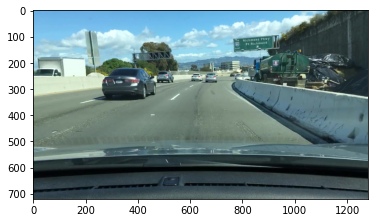

In [ ]:
images_list = os.listdir('test/')
img = imread('./test/'+images_list[20])
plt.imshow(img)

In [ ]:
ystart_ystop_scale = [(200, 500,1), (200, 500, 1.5), (200, 500, 3)]
bbox_detection_list, pred_array = find_cars(img, clf, scaler, ystart_ystop_scale, vocab)

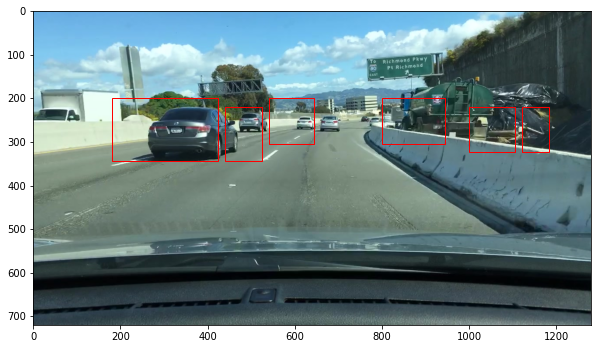

In [ ]:
new_boxes = box_otsu(pred_array)
new_boxes = non_max_suppression(np.array(new_boxes), 0.8)

fig, ax = plt.subplots(figsize=(10, 8))

for x, y, dx, dy in new_boxes:

    rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(img)
